<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>[Yolanda Meng]</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Tuesday, April 15, 2025, 11:59 PM**


* Total marks: 49


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [125]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [126]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [127]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [128]:
X_raw.shape

(16512, 9)

In [129]:
X_raw[X_raw.isnull().any(axis=1)].shape

(168, 9)

In [130]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

**Solution:**

In [131]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_1 = X_raw.drop("ocean_proximity", axis=1)
imputer.fit(X_1)


SimpleImputer(strategy='median')

In [132]:
print(imputer.statistics_)
print(X_1.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [133]:
X =imputer.transform(X_1)
tr = pd.DataFrame(X, columns=X_1.columns, index=X_1.index)
tr[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

In [134]:
X_c = X_raw[["ocean_proximity"]]
X_c.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [135]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
ordinal_encoder = OrdinalEncoder()
X_c_encoded = ordinal_encoder.fit_transform(X_c)
print(X_c_encoded[:10])
print(ordinal_encoder.categories_)

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [136]:
cat_encoder = OneHotEncoder(sparse_output=False)
X_c_1hot = cat_encoder.fit_transform(X_c)
print(X_c_1hot[:10])
print(cat_encoder.categories_)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


It is more appropriate to use one-hot encoding for the ocean_proximity feature because this variable represents nominal categories — such as “INLAND,” “NEAR OCEAN,” or “ISLAND” — which have no inherent order or ranking. If we use ordinal encoding, each category is assigned a number (e.g., 0, 1, 2…), and this implies a false sense of order or magnitude between the categories. As a result, machine learning models might wrongly assume that one category is "larger" or "closer" than another, which can mislead the training process. One-hot encoding solves this by creating binary indicator variables for each category, ensuring that all are treated equally and independently, without any assumptions about order. This helps models capture category-specific effects more appropriately.

## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [138]:
from sklearn.preprocessing import FunctionTransformer

pd.reset_option("display.max_rows", silent=True)
pd.reset_option("display.max_columns", silent=True)

log_transformer = FunctionTransformer(np.log1p, feature_names_out='one-to-one')
log_pop = log_transformer.fit_transform(housing[["population"]])
log_pop_df = pd.DataFrame(log_pop, columns=["population"])

def bedroom_to_room(X):
    return X[:, [0]] / X[:, [1]]

ratio_transformer = FunctionTransformer(bedroom_to_room, feature_names_out='one-to-one')
bedroom_room_array = ratio_transformer.fit_transform(housing[["total_bedrooms", "total_rooms"]].to_numpy())
bedroom_ratio_df = pd.DataFrame(bedroom_room_array, columns=["bedroom_room_ratio"])
print(log_pop_df)


       population
0        5.777652
1        7.784057
2        6.208590
3        6.326149
4        6.338594
...           ...
20635    6.740519
20636    5.877736
20637    6.915723
20638    6.609349
20639    7.235619

[20640 rows x 1 columns]


In [139]:
print(bedroom_ratio_df)

       bedroom_room_ratio
0                0.146591
1                0.155797
2                0.129516
3                0.184458
4                0.172096
...                   ...
20635            0.224625
20636            0.215208
20637            0.215173
20638            0.219892
20639            0.221185

[20640 rows x 1 columns]


## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization. 

**Solution:**

In [140]:
from sklearn.preprocessing import StandardScaler

numerical_features = X_raw.select_dtypes(include=["float64", "int64"]).copy()
scaler = StandardScaler()
scaled_array = scaler.fit_transform(numerical_features)
scaled_df = pd.DataFrame(scaled_array, columns=numerical_features.columns, index=X_raw.index)
print(scaled_df.head())


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.359094   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.436356   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.759584   
14689   1.231216 -0.884924           -0.919891     0.702262        0.736231   
20507   0.711362 -0.875549            0.589800     0.790125        1.585590   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365  


## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

In [141]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(transformer, feature_names_in):
    return ["_div_".join(feature_names_in)]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

X = preprocessing.fit_transform(X_raw)

X_df = pd.DataFrame(X, columns=preprocessing.get_feature_names_out(), index=X_raw.index)

print("Transformed feature matrix:")
print(X_df.head())


Transformed feature matrix:
       bedrooms__total_bedrooms_div_total_rooms  \
13096                                  1.846624   
14973                                 -0.508121   
3785                                  -0.202155   
14689                                 -0.149006   
20507                                  0.963208   

       rooms_per_house__total_rooms_div_households  \
13096                                    -0.866027   
14973                                     0.024550   
3785                                     -0.041193   
14689                                    -0.034858   
20507                                    -0.666554   

       people_per_house__population_div_households  log__total_bedrooms  \
13096                                    -0.330204             1.324114   
14973                                    -0.253616            -0.252671   
3785                                     -0.051041            -0.925266   
14689                                   

In [142]:
from IPython.display import display
display(X_df.head())

,bedrooms__total_bedrooms_div_total_rooms,rooms_per_house__total_rooms_div_households,people_per_house__population_div_households,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,0.0,0.0,0.0,1.0,0.0,-1.423037,1.013606,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.0,0.0,0.0,0.0,0.0,0.596394,-0.702103,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,0.0,1.0,0.0,0.0,0.0,-1.203098,1.276119,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,0.0,1.0,0.0,0.0,0.0,1.231216,-0.884924,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,0.0,0.0,0.0,0.0,1.0,0.711362,-0.875549,0.589800


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [143]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X_df[:10])

print("Fitted values for the first 10 observations:")
print(predictions)


Fitted values for the first 10 observations:
[260051.36004114 357897.79846769 125817.08984353 110019.21093156
 298948.54915206 206437.53193813 306787.013961   326902.92850959
 162297.74181859  68786.66157655]


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

train_predictions = model.predict(X)
mse = mean_squared_error(y, train_predictions)
rmse_score = np.sqrt(mse)
mae_score = mean_absolute_error(y, train_predictions)

print("Linear Regression In-Sample Evaluation")
print("RMSE:", rmse_score)
print("MAE :", mae_score)


Linear Regression In-Sample Evaluation
RMSE: 70630.22169174395
MAE : 53034.28396497741


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**Solution:**

In [145]:
from sklearn.model_selection import cross_val_score

neg_mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-neg_mse_scores)

print("RMSE scores:\n", rmse_scores)
print("\nMean RMSE:", rmse_scores.mean())


RMSE scores:
 [72183.9055149  69449.07233135 68141.82330925 82348.92814938
 70200.08524327 70974.12115166 70512.16910063 73276.85042458
 69387.52951303 71463.70091766]

Mean RMSE: 71793.81856557204


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [146]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [59]:
dt_reg.predict(X[:10,])

array([458300., 483800., 101700.,  96100., 361800.,  92600., 349300.,
       440900., 160100., 183900.])

The following code does the same for the random forest model.

In [147]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [148]:
rf_reg.predict(X[:10,])

array([226052.57663663, 408572.3162281 , 100944.59292661,  95012.98416211,
       323566.08786234, 135098.37280907, 283371.7148996 , 357336.26089032,
       167697.90412093, 146436.2407077 ])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [149]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, y)

tree_train_preds = tree_model.predict(X)
tree_rmse = np.sqrt(mean_squared_error(y, tree_train_preds))
print("Decision Tree - In-sample RMSE:", tree_rmse)

tree_cv_mse = cross_val_score(tree_model, X, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_cv = np.sqrt(-tree_cv_mse)
print("Decision Tree - CV RMSE scores:", tree_rmse_cv)
print("Decision Tree - Mean CV RMSE:", tree_rmse_cv.mean())


Decision Tree - In-sample RMSE: 0.0
Decision Tree - CV RMSE scores: [67898.40100744 67248.54149778 67243.39802711 72035.287263
 68898.44321855 71008.46519973 71362.02678113 74060.25775818
 71016.06635454 69991.86971249]
Decision Tree - Mean CV RMSE: 70076.27568199515


In [150]:
# Random Forest In-sample RMSE
forest_pred = rf_reg.predict(X)
forest_rmse = np.sqrt(mean_squared_error(y, forest_pred))
print("\nRandom Forest In-sample RMSE:",forest_rmse)
# Random Forest CV RMSE
forest_scores = cross_val_score(rf_reg, X, y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("\nRandom Forest CV RMSEs:\n"
, forest_rmse_scores)
print("\nRandom Forest Mean CV RMSE:", forest_rmse_scores.mean())


Random Forest In-sample RMSE: 62145.4331743811

Random Forest CV RMSEs:
 [64285.5681693  64416.01160789 61285.39123064 62717.91644372
 62975.51019993 64267.50742936 64049.97630137 64749.28015876
 63792.05556927 64654.70321247]

Random Forest Mean CV RMSE: 63719.39203227045


The Decision Tree model achieves the lowest in-sample RMSE of 0.0, perfectly fitting the training data but strongly indicating overfitting. In contrast, the Random Forest model has a higher in-sample RMSE of 62,145.43, suggesting a more generalizable fit that avoids memorizing the data. When evaluated using 10-fold cross-validation, the Decision Tree performs poorly out-of-sample, with RMSE values ranging from 67,243.40 to 74,060.26 and a mean of 70,076.28, highlighting its lack of consistency. The Random Forest, however, demonstrates more stable and reliable generalization, with RMSE values between 61,285.39 and 64,749.28 and a lower mean RMSE of 63,719.39. Overall, while the Decision Tree shows the best in-sample performance, the Random Forest clearly provides the best out-of-sample performance.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = {
    "random_forest__max_features": [4, 6, 8, 10],
    "random_forest__n_estimators": [10, 50, 100]
}

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_raw, y)

print("Best parameters found:", grid_search.best_params_)
print("Lowest RMSE from GridSearch:", -grid_search.best_score_)


Best parameters found: {'random_forest__max_features': 6, 'random_forest__n_estimators': 100}
Lowest RMSE from GridSearch: 49464.873628139816


In [152]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

param_distributions = {
    "random_forest__max_features": randint(2, 20),
    "random_forest__n_estimators": randint(10, 200)
}

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_raw, y)

print("Best parameters from RandomizedSearchCV:", random_search.best_params_)
print("Best RMSE from random search:", -random_search.best_score_)


Best parameters from RandomizedSearchCV: {'random_forest__max_features': 7, 'random_forest__n_estimators': 139}
Best RMSE from random search: 49277.896103688865


## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

In [154]:
from sklearn.metrics import mean_squared_error
import numpy as np

final_model = random_search.best_estimator_
X_test_final = strat_test_set.drop("median_house_value", axis=1)
y_test_final = strat_test_set["median_house_value"].copy()
y_test_pred = final_model.predict(X_test_final)

final_test_rmse = np.sqrt(mean_squared_error(y_test_final, y_test_pred))

print("Final RMSE on the test set:", final_test_rmse)


Final RMSE on the test set: 49016.24364007325


After testing the optimized model from part 2(e) on the test dataset, the resulting RMSE was 49,016.24, indicating the model’s predictive error on unseen data. This value serves as an estimate of how well the model generalizes beyond the training set, providing insight into its out-of-sample performance. A lower RMSE suggests the model is effective at capturing patterns in the data without overfitting.

# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

In [155]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

poly_transformer = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_transformer.fit_transform(X)

poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_poly, y)
poly_preds = poly_lin_reg.predict(X_poly[:10])
print("Polynomial Regression Predictions (first 10):")
print(np.round(poly_preds, 2))

ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_poly, y)
ridge_preds = ridge_reg.predict(X_poly[:10])
print("\nRidge Regression (Regularized) Predictions (first 10):")
print(np.round(ridge_preds, 2))


Polynomial Regression Predictions (first 10):
[356123.33 439195.6   97669.21 113155.52 357167.45 154690.18 315691.36
 409573.5  175693.41 186390.62]

Ridge Regression (Regularized) Predictions (first 10):
[369105.72 453699.49  97767.85 113300.5  353346.88 159157.17 310510.81
 386469.94 172668.83 185983.64]


## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

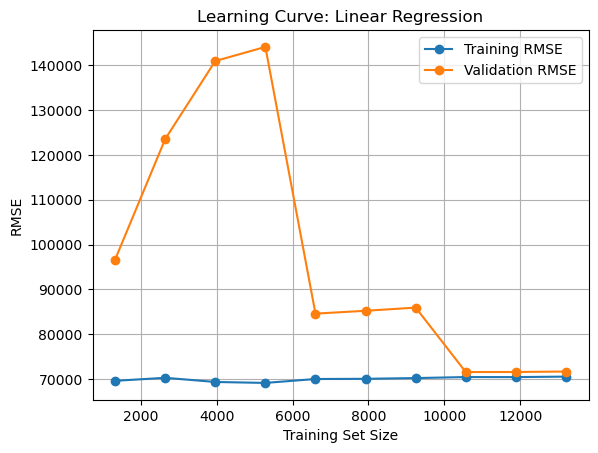

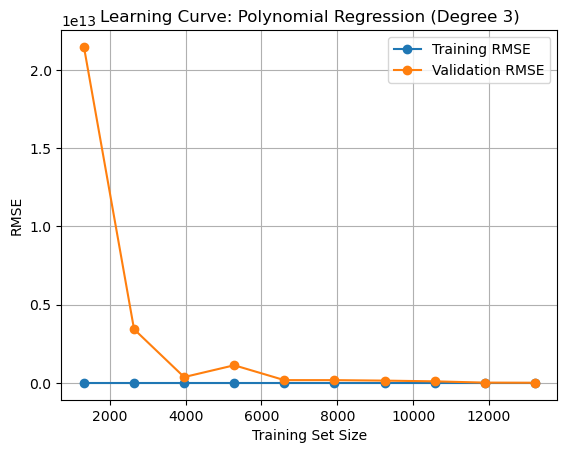

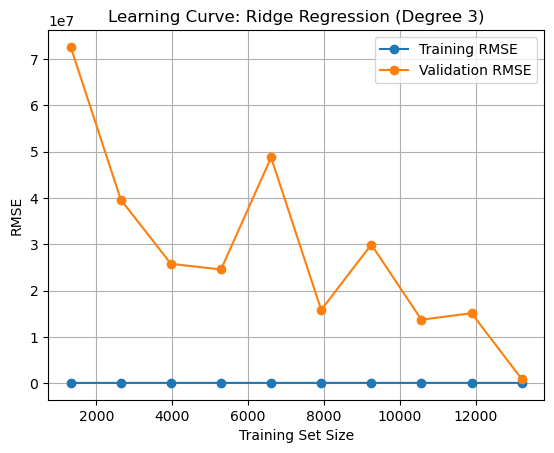

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_rmse = -train_scores
    val_rmse = -val_scores

    train_rmse_mean = train_rmse.mean(axis=1)
    val_rmse_mean = val_rmse.mean(axis=1)

    plt.plot(train_sizes, train_rmse_mean, "o-", label="Training RMSE")
    plt.plot(train_sizes, val_rmse_mean, "o-", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y, "Learning Curve: Linear Regression")

poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
plot_learning_curve(poly_pipeline, X, y, "Learning Curve: Polynomial Regression (Degree 3)")

ridge_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    Ridge(alpha=1)
)
plot_learning_curve(ridge_pipeline, X, y, "Learning Curve: Ridge Regression (Degree 3)")


# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [157]:
import pandas as pd
data = pd.read_csv("Default-2.csv", header=1)
print(data.head())

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


**Solution:**

In [158]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
train_copy = train_set.copy()
print(train_copy.head())

     default student      balance        income
9254      No      No  1018.568130  34103.879520
1561      No      No    62.170050  28660.747508
1670      No      No  1046.743543  40822.447413
6087      No      No   763.735280  44125.718725
6669      No     Yes   697.248633  25730.917583


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

In [159]:
y_tr = train_copy["default"].values=="Yes" 
X_train= train_copy.drop("default", axis=1)
categorical_cols = ['student']
numerical_cols = ['balance', 'income']
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numerical_cols),
('cat', OneHotEncoder(), categorical_cols)
]
)
pipeline = Pipeline([('preprocessor', preprocessor)])
X_tr_preprocessed = pipeline.fit_transform(X_train)
X_tr_preprocessed

array([[ 0.38108223,  0.03730779,  1.        ,  0.        ],
       [-1.59177438, -0.37009867,  1.        ,  0.        ],
       [ 0.43920243,  0.54017781,  1.        ,  0.        ],
       ...,
       [-0.23061793, -0.49558035,  1.        ,  0.        ],
       [-1.38184384, -0.93727606,  0.        ,  1.        ],
       [-0.40531852,  1.20145415,  1.        ,  0.        ]])

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

In [160]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_tr)
log_reg = LogisticRegression(random_state=42)
sgd = SGDClassifier(loss="log_loss", random_state=42)

y_scores_log = cross_val_predict(log_reg, X_tr_preprocessed, y_train_encoded, cv=10, method='decision_function')
y_scores_sgd = cross_val_predict(sgd, X_tr_preprocessed, y_train_encoded, cv=10, method='decision_function')

auc_log = roc_auc_score(y_train_encoded, y_scores_log)
auc_sgd = roc_auc_score(y_train_encoded, y_scores_sgd)

print(f"Logistic Regression ROC AUC: {auc_log:.6f}")
print(f"SGD Classifier ROC AUC:     {auc_sgd:.6f}")

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg, param_grid, scoring='roc_auc', cv=10, n_jobs=-1)
grid_search.fit(X_tr_preprocessed, y_train_encoded)

print("\nBest parameter (C):", grid_search.best_params_['C'])
print(f"Best ROC AUC from GridSearchCV: {grid_search.best_score_:.6f}")

print("\nAUC scores for each C value:")
for mean_score, std_score, param in zip(
    grid_search.cv_results_['mean_test_score'],
    grid_search.cv_results_['std_test_score'],
    grid_search.cv_results_['params']
):
    print(f"C = {param['C']:>6} | AUC = {mean_score:.6f} ± {std_score:.6f}")


Logistic Regression ROC AUC: 0.950148
SGD Classifier ROC AUC:     0.947096

Best parameter (C): 1
Best ROC AUC from GridSearchCV: 0.951213

AUC scores for each C value:
C =  0.001 | AUC = 0.947156 ± 0.019471
C =   0.01 | AUC = 0.950528 ± 0.018888
C =    0.1 | AUC = 0.951047 ± 0.018838
C =      1 | AUC = 0.951213 ± 0.018948
C =     10 | AUC = 0.951198 ± 0.018980
C =    100 | AUC = 0.951188 ± 0.018994


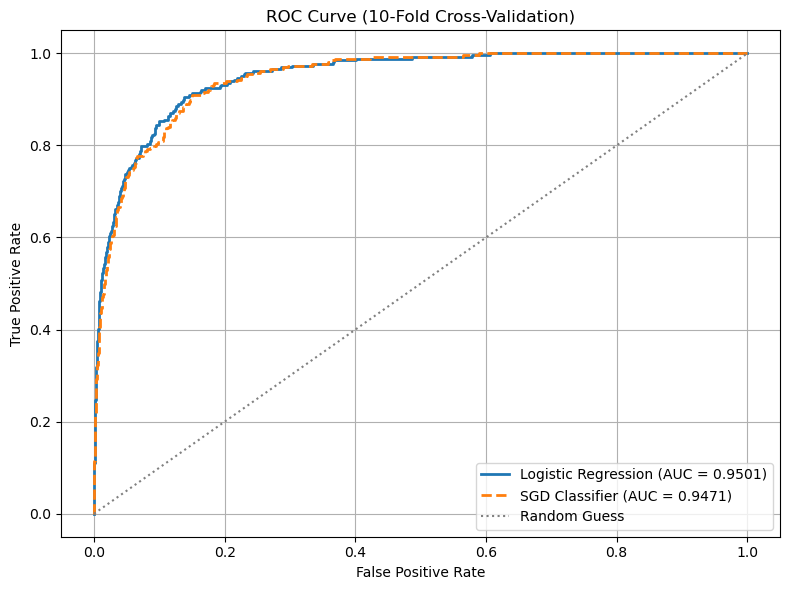

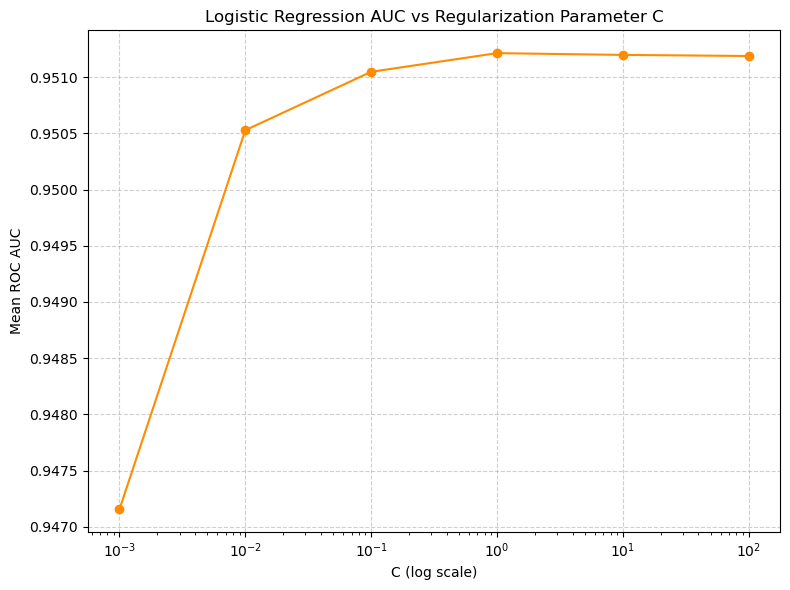

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(y_train_encoded, y_scores_log)
fpr_sgd, tpr_sgd, _ = roc_curve(y_train_encoded, y_scores_sgd)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.4f})', linewidth=2)
plt.plot(fpr_sgd, tpr_sgd, linestyle='--', label=f'SGD Classifier (AUC = {auc_sgd:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (10-Fold Cross-Validation)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

C_vals = [param['C'] for param in grid_search.cv_results_['params']]
auc_vals = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.semilogx(C_vals, auc_vals, marker='o', color='darkorange')
plt.xlabel("C (log scale)")
plt.ylabel("Mean ROC AUC")
plt.title("Logistic Regression AUC vs Regularization Parameter C")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

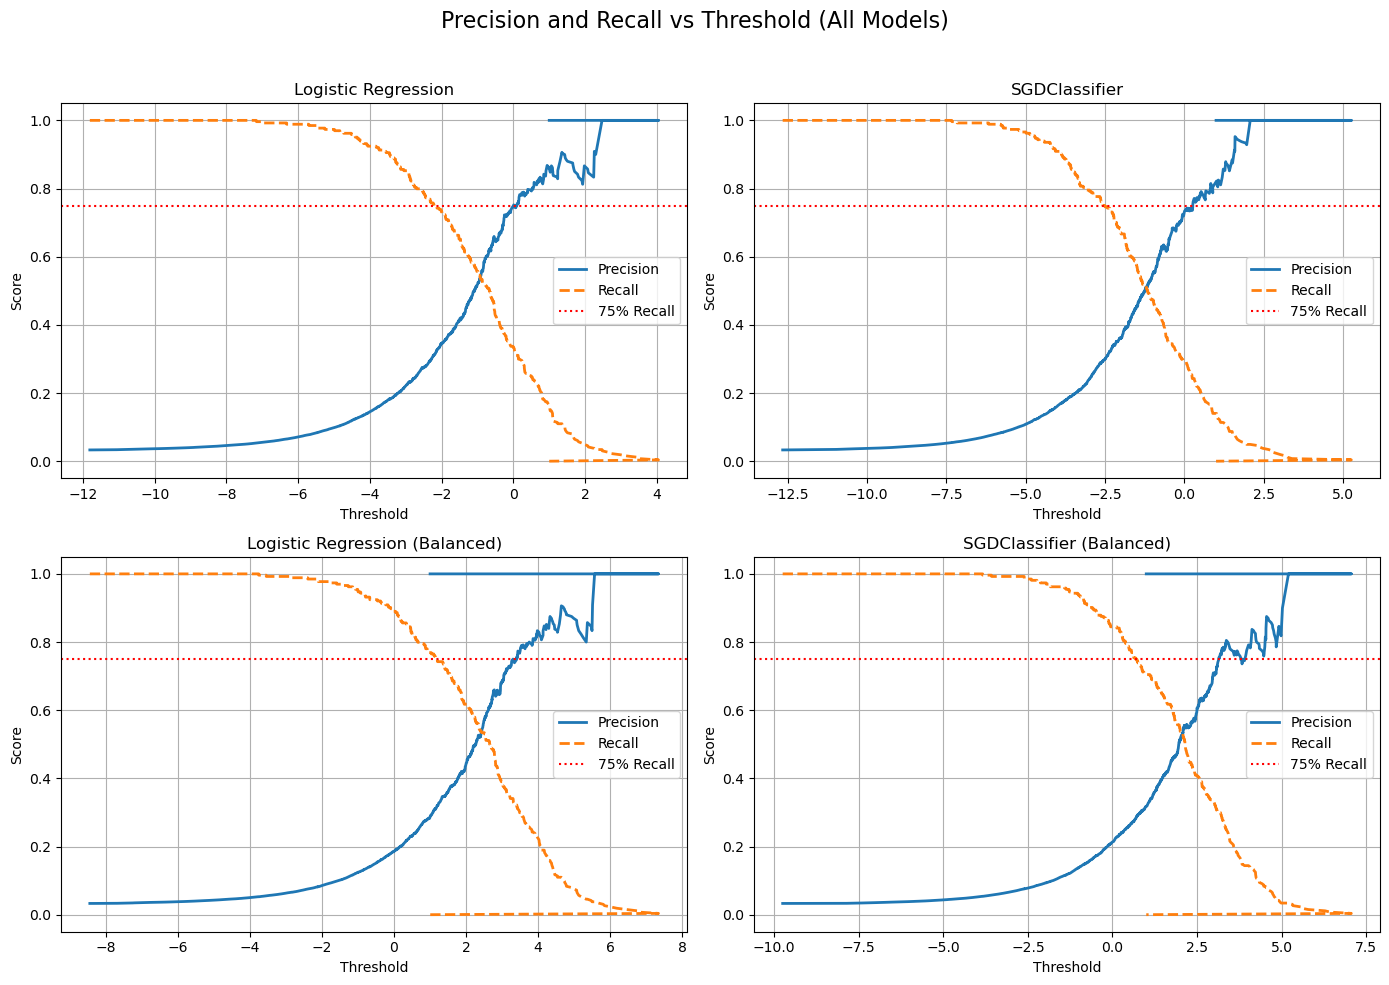

                         Model  Optimal Threshold  Precision  Recall
           Logistic Regression          -2.147446   0.323002    0.75
                 SGDClassifier          -2.500737   0.300000    0.75
Logistic Regression (Balanced)           1.200437   0.320908    0.75
      SGDClassifier (Balanced)           0.722519   0.289474    0.75

🏆 Best precision at 75% recall: Logistic Regression (0.323002)


In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

log_reg = LogisticRegression(random_state=42)
sgd = SGDClassifier(loss="log_loss", random_state=42)
log_reg_bal = LogisticRegression(class_weight="balanced", random_state=42)
sgd_bal = SGDClassifier(loss="log_loss", class_weight="balanced", random_state=42)

def get_model_curve(clf, model_name, ax):
    y_scores = cross_val_predict(clf, X_tr_preprocessed, y_tr, cv=10, method='decision_function')
    precisions, recalls, thresholds = precision_recall_curve(y_tr, y_scores)
    thresholds = np.append(thresholds, 1.0)

  
    ax.plot(thresholds, precisions, label="Precision", linewidth=2)
    ax.plot(thresholds, recalls, label="Recall", linestyle='--', linewidth=2)
    ax.axhline(0.75, color='red', linestyle=':', label="75% Recall")
    ax.set_title(model_name)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

    idx = np.where(recalls[:-1] >= 0.75)[0]
    if len(idx) > 0:
        best_idx = idx[-1]
        return thresholds[best_idx], precisions[best_idx], recalls[best_idx]
    else:
        return np.nan, np.nan, np.nan

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

log_reg_optimal_threshold, log_reg_precision, log_reg_recall = get_model_curve(log_reg, "Logistic Regression", axs[0])
SGD_optimal_threshold, SGD_precision, SGD_recall = get_model_curve(sgd, "SGDClassifier", axs[1])
log_reg_bal_optimal_threshold, log_reg_bal_precision, log_reg_bal_recall = get_model_curve(log_reg_bal, "Logistic Regression (Balanced)", axs[2])
SGD_bal_optimal_threshold, SGD_bal_precision, SGD_bal_recall = get_model_curve(sgd_bal, "SGDClassifier (Balanced)", axs[3])

plt.suptitle("Precision and Recall vs Threshold (All Models)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

data_summary = {
    "Model": [
        "Logistic Regression",
        "SGDClassifier",
        "Logistic Regression (Balanced)",
        "SGDClassifier (Balanced)"
    ],
    "Optimal Threshold": [
        round(log_reg_optimal_threshold, 6),
        round(SGD_optimal_threshold, 6),
        round(log_reg_bal_optimal_threshold, 6),
        round(SGD_bal_optimal_threshold, 6)
    ],
    "Precision": [
        round(log_reg_precision, 6),
        round(SGD_precision, 6),
        round(log_reg_bal_precision, 6),
        round(SGD_bal_precision, 6)
    ],
    "Recall": [
        round(log_reg_recall, 6),
        round(SGD_recall, 6),
        round(log_reg_bal_recall, 6),
        round(SGD_bal_recall, 6)
    ]
}

df_summary = pd.DataFrame(data_summary)

print(df_summary.to_string(index=False))

best_idx = df_summary["Precision"].idxmax()
best_model = df_summary.iloc[best_idx]
print(f"\n🏆 Best precision at 75% recall: {best_model['Model']} ({best_model['Precision']})")


## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**

Test Accuracy: 0.9330
Test Precision: 0.2903
Test Recall: 0.6522
Test ROC AUC: 0.9435


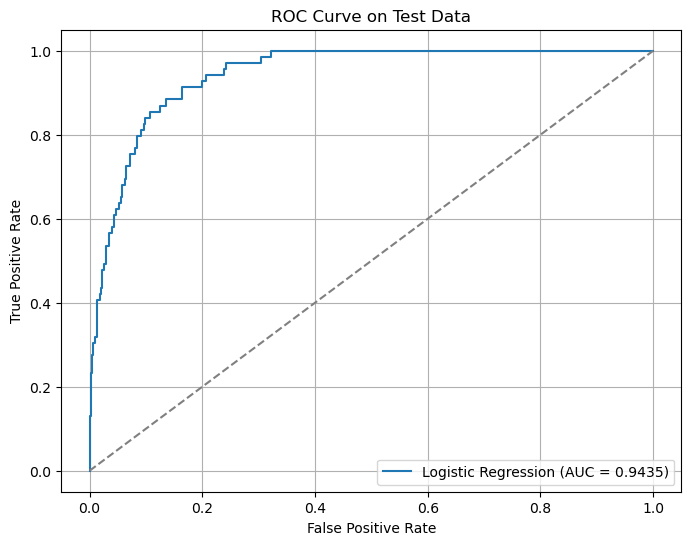

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression

test_data_copy = test_set.copy()
X_test = test_data_copy.drop("default", axis=1)
y_test = (test_data_copy["default"] == "Yes")
X_test_prepared = pipeline.transform(X_test)

final_clf = LogisticRegression()
final_clf.fit(X_tr_preprocessed, y_tr)

test_scores = final_clf.decision_function(X_test_prepared)
threshold = log_reg_optimal_threshold
y_pred_test = test_scores >= threshold

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, test_scores)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test ROC AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
